In [1]:
import math
import random
import torch # v0.4.1
from torch import nn
from torch.nn import functional as F
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def net(x, params):
    x = F.linear(x, params[0], params[1])
    x1 = F.relu(x)

    x = F.linear(x1, params[2], params[3])
    x2 = F.relu(x)

    y = F.linear(x2, params[4], params[5])

    return y, x2, x1


In [3]:
def adap_net(y, x2, x1, params):
    x = torch.cat([y, x2, x1], dim=1)

    x = F.linear(x, params[0], params[1])
    x = F.relu(x)

    x = F.linear(x, params[2], params[3])
    x = F.relu(x)

    x = F.linear(x, params[4], params[5])

    return x


In [4]:
params = [
    torch.Tensor(32, 1).uniform_(-1., 1.).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(32, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(1, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(1).zero_().requires_grad_(),
]

adap_params = [
    torch.Tensor(32, 1+32+32).uniform_(-1./math.sqrt(65), 1./math.sqrt(65)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(32, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(1, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(1).zero_().requires_grad_(),
]


In [5]:
opt = torch.optim.SGD(params + adap_params, lr=1e-2)
n_inner_loop = 5
alpha = 3e-2


In [6]:
for it in range(100000):
    b = 0 if random.choice([True, False]) else math.pi

    v_x = torch.rand(4, 1)*4*math.pi - 2*math.pi
    v_y = torch.sin(v_x + b)

    opt.zero_grad()

    new_params = params
    for k in range(n_inner_loop):
        f, f2, f1 = net(torch.FloatTensor([[random.uniform(math.pi/4, math.pi/2) if b == 0 else random.uniform(-math.pi/2, -math.pi/4)]]), new_params)
        h = adap_net(f, f2, f1, adap_params)
        adap_loss = F.l1_loss(h, torch.zeros(1, 1))

        # create_graph=True because computing grads here is part of the forward pass.
        # We want to differentiate through the SGD update steps and get higher order
        # derivatives in the backward pass.
        grads = torch.autograd.grad(adap_loss, new_params, create_graph=True)
        new_params = [(new_params[i] - alpha*grads[i]) for i in range(len(params))]

        if it % 100 == 0: 
            print ('Iteration %d -- Inner loop %d -- Loss: %.4f' % (it, k, adap_loss))

    v_f, _, _ = net(v_x, new_params)
    loss = F.l1_loss(v_f, v_y)
    loss.backward()

    opt.step()

    if it % 100 == 0: 
        print ('Iteration %d -- Outer Loss: %.4f' % (it, loss))


Iteration 0 -- Inner loop 0 -- Loss: 0.0257
Iteration 0 -- Inner loop 1 -- Loss: 0.0151
Iteration 0 -- Inner loop 2 -- Loss: 0.0249
Iteration 0 -- Inner loop 3 -- Loss: 0.0199
Iteration 0 -- Inner loop 4 -- Loss: 0.0228
Iteration 0 -- Outer Loss: 0.8298
Iteration 100 -- Inner loop 0 -- Loss: 0.0356
Iteration 100 -- Inner loop 1 -- Loss: 0.0358
Iteration 100 -- Inner loop 2 -- Loss: 0.0322
Iteration 100 -- Inner loop 3 -- Loss: 0.0389
Iteration 100 -- Inner loop 4 -- Loss: 0.0384
Iteration 100 -- Outer Loss: 0.6585
Iteration 200 -- Inner loop 0 -- Loss: 0.0356
Iteration 200 -- Inner loop 1 -- Loss: 0.0321
Iteration 200 -- Inner loop 2 -- Loss: 0.0370
Iteration 200 -- Inner loop 3 -- Loss: 0.0343
Iteration 200 -- Inner loop 4 -- Loss: 0.0379
Iteration 200 -- Outer Loss: 0.7446
Iteration 300 -- Inner loop 0 -- Loss: 0.0336
Iteration 300 -- Inner loop 1 -- Loss: 0.0368
Iteration 300 -- Inner loop 2 -- Loss: 0.0216
Iteration 300 -- Inner loop 3 -- Loss: 0.0237
Iteration 300 -- Inner loop 4 

Iteration 3100 -- Inner loop 0 -- Loss: 0.0398
Iteration 3100 -- Inner loop 1 -- Loss: 0.0341
Iteration 3100 -- Inner loop 2 -- Loss: 0.0259
Iteration 3100 -- Inner loop 3 -- Loss: 0.0266
Iteration 3100 -- Inner loop 4 -- Loss: 0.0193
Iteration 3100 -- Outer Loss: 0.7758
Iteration 3200 -- Inner loop 0 -- Loss: 0.0165
Iteration 3200 -- Inner loop 1 -- Loss: 0.0114
Iteration 3200 -- Inner loop 2 -- Loss: 0.0059
Iteration 3200 -- Inner loop 3 -- Loss: 0.0077
Iteration 3200 -- Inner loop 4 -- Loss: 0.0086
Iteration 3200 -- Outer Loss: 0.7199
Iteration 3300 -- Inner loop 0 -- Loss: 0.0210
Iteration 3300 -- Inner loop 1 -- Loss: 0.0261
Iteration 3300 -- Inner loop 2 -- Loss: 0.0192
Iteration 3300 -- Inner loop 3 -- Loss: 0.0164
Iteration 3300 -- Inner loop 4 -- Loss: 0.0239
Iteration 3300 -- Outer Loss: 0.8007
Iteration 3400 -- Inner loop 0 -- Loss: 0.0196
Iteration 3400 -- Inner loop 1 -- Loss: 0.0205
Iteration 3400 -- Inner loop 2 -- Loss: 0.0101
Iteration 3400 -- Inner loop 3 -- Loss: 0.0

Iteration 6200 -- Inner loop 0 -- Loss: 0.0172
Iteration 6200 -- Inner loop 1 -- Loss: 0.0156
Iteration 6200 -- Inner loop 2 -- Loss: 0.0046
Iteration 6200 -- Inner loop 3 -- Loss: 0.0106
Iteration 6200 -- Inner loop 4 -- Loss: 0.0101
Iteration 6200 -- Outer Loss: 0.6924
Iteration 6300 -- Inner loop 0 -- Loss: 0.0368
Iteration 6300 -- Inner loop 1 -- Loss: 0.0277
Iteration 6300 -- Inner loop 2 -- Loss: 0.0311
Iteration 6300 -- Inner loop 3 -- Loss: 0.0272
Iteration 6300 -- Inner loop 4 -- Loss: 0.0342
Iteration 6300 -- Outer Loss: 0.5731
Iteration 6400 -- Inner loop 0 -- Loss: 0.0216
Iteration 6400 -- Inner loop 1 -- Loss: 0.0157
Iteration 6400 -- Inner loop 2 -- Loss: 0.0123
Iteration 6400 -- Inner loop 3 -- Loss: 0.0165
Iteration 6400 -- Inner loop 4 -- Loss: 0.0187
Iteration 6400 -- Outer Loss: 0.8091
Iteration 6500 -- Inner loop 0 -- Loss: 0.0260
Iteration 6500 -- Inner loop 1 -- Loss: 0.0337
Iteration 6500 -- Inner loop 2 -- Loss: 0.0354
Iteration 6500 -- Inner loop 3 -- Loss: 0.0

Iteration 9300 -- Inner loop 0 -- Loss: 0.0119
Iteration 9300 -- Inner loop 1 -- Loss: 0.0080
Iteration 9300 -- Inner loop 2 -- Loss: 0.0084
Iteration 9300 -- Inner loop 3 -- Loss: 0.0088
Iteration 9300 -- Inner loop 4 -- Loss: 0.0025
Iteration 9300 -- Outer Loss: 0.6329
Iteration 9400 -- Inner loop 0 -- Loss: 0.0100
Iteration 9400 -- Inner loop 1 -- Loss: 0.0066
Iteration 9400 -- Inner loop 2 -- Loss: 0.0051
Iteration 9400 -- Inner loop 3 -- Loss: 0.0102
Iteration 9400 -- Inner loop 4 -- Loss: 0.0081
Iteration 9400 -- Outer Loss: 0.6692
Iteration 9500 -- Inner loop 0 -- Loss: 0.0228
Iteration 9500 -- Inner loop 1 -- Loss: 0.0209
Iteration 9500 -- Inner loop 2 -- Loss: 0.0141
Iteration 9500 -- Inner loop 3 -- Loss: 0.0120
Iteration 9500 -- Inner loop 4 -- Loss: 0.0084
Iteration 9500 -- Outer Loss: 0.2088
Iteration 9600 -- Inner loop 0 -- Loss: 0.0096
Iteration 9600 -- Inner loop 1 -- Loss: 0.0156
Iteration 9600 -- Inner loop 2 -- Loss: 0.0041
Iteration 9600 -- Inner loop 3 -- Loss: 0.0

Iteration 12300 -- Inner loop 0 -- Loss: 0.0356
Iteration 12300 -- Inner loop 1 -- Loss: 0.0292
Iteration 12300 -- Inner loop 2 -- Loss: 0.0246
Iteration 12300 -- Inner loop 3 -- Loss: 0.0208
Iteration 12300 -- Inner loop 4 -- Loss: 0.0114
Iteration 12300 -- Outer Loss: 0.8887
Iteration 12400 -- Inner loop 0 -- Loss: 0.0324
Iteration 12400 -- Inner loop 1 -- Loss: 0.0294
Iteration 12400 -- Inner loop 2 -- Loss: 0.0283
Iteration 12400 -- Inner loop 3 -- Loss: 0.0256
Iteration 12400 -- Inner loop 4 -- Loss: 0.0201
Iteration 12400 -- Outer Loss: 0.4388
Iteration 12500 -- Inner loop 0 -- Loss: 0.0353
Iteration 12500 -- Inner loop 1 -- Loss: 0.0352
Iteration 12500 -- Inner loop 2 -- Loss: 0.0285
Iteration 12500 -- Inner loop 3 -- Loss: 0.0259
Iteration 12500 -- Inner loop 4 -- Loss: 0.0204
Iteration 12500 -- Outer Loss: 0.6266
Iteration 12600 -- Inner loop 0 -- Loss: 0.0137
Iteration 12600 -- Inner loop 1 -- Loss: 0.0106
Iteration 12600 -- Inner loop 2 -- Loss: 0.0043
Iteration 12600 -- Inn

Iteration 15300 -- Inner loop 0 -- Loss: 0.0121
Iteration 15300 -- Inner loop 1 -- Loss: 0.0070
Iteration 15300 -- Inner loop 2 -- Loss: 0.0080
Iteration 15300 -- Inner loop 3 -- Loss: 0.0025
Iteration 15300 -- Inner loop 4 -- Loss: 0.0068
Iteration 15300 -- Outer Loss: 0.6852
Iteration 15400 -- Inner loop 0 -- Loss: 0.0111
Iteration 15400 -- Inner loop 1 -- Loss: 0.0064
Iteration 15400 -- Inner loop 2 -- Loss: 0.0042
Iteration 15400 -- Inner loop 3 -- Loss: 0.0038
Iteration 15400 -- Inner loop 4 -- Loss: 0.0027
Iteration 15400 -- Outer Loss: 0.5591
Iteration 15500 -- Inner loop 0 -- Loss: 0.1084
Iteration 15500 -- Inner loop 1 -- Loss: 0.0822
Iteration 15500 -- Inner loop 2 -- Loss: 0.0245
Iteration 15500 -- Inner loop 3 -- Loss: 0.0183
Iteration 15500 -- Inner loop 4 -- Loss: 0.0111
Iteration 15500 -- Outer Loss: 0.7442
Iteration 15600 -- Inner loop 0 -- Loss: 0.1415
Iteration 15600 -- Inner loop 1 -- Loss: 0.1070
Iteration 15600 -- Inner loop 2 -- Loss: 0.0720
Iteration 15600 -- Inn

Iteration 18300 -- Inner loop 0 -- Loss: 0.4154
Iteration 18300 -- Inner loop 1 -- Loss: 0.2115
Iteration 18300 -- Inner loop 2 -- Loss: 0.0984
Iteration 18300 -- Inner loop 3 -- Loss: 0.0448
Iteration 18300 -- Inner loop 4 -- Loss: 0.2197
Iteration 18300 -- Outer Loss: 0.4926
Iteration 18400 -- Inner loop 0 -- Loss: 0.0009
Iteration 18400 -- Inner loop 1 -- Loss: 0.0033
Iteration 18400 -- Inner loop 2 -- Loss: 0.0018
Iteration 18400 -- Inner loop 3 -- Loss: 0.0028
Iteration 18400 -- Inner loop 4 -- Loss: 0.0013
Iteration 18400 -- Outer Loss: 0.5942
Iteration 18500 -- Inner loop 0 -- Loss: 0.5346
Iteration 18500 -- Inner loop 1 -- Loss: 0.4185
Iteration 18500 -- Inner loop 2 -- Loss: 0.0253
Iteration 18500 -- Inner loop 3 -- Loss: 0.1141
Iteration 18500 -- Inner loop 4 -- Loss: 0.0903
Iteration 18500 -- Outer Loss: 0.2912
Iteration 18600 -- Inner loop 0 -- Loss: 0.0081
Iteration 18600 -- Inner loop 1 -- Loss: 0.0021
Iteration 18600 -- Inner loop 2 -- Loss: 0.0010
Iteration 18600 -- Inn

Iteration 21300 -- Inner loop 0 -- Loss: 0.0326
Iteration 21300 -- Inner loop 1 -- Loss: 0.0091
Iteration 21300 -- Inner loop 2 -- Loss: 0.0206
Iteration 21300 -- Inner loop 3 -- Loss: 0.0141
Iteration 21300 -- Inner loop 4 -- Loss: 0.0175
Iteration 21300 -- Outer Loss: 0.3557
Iteration 21400 -- Inner loop 0 -- Loss: 1.5503
Iteration 21400 -- Inner loop 1 -- Loss: 0.7834
Iteration 21400 -- Inner loop 2 -- Loss: 0.3789
Iteration 21400 -- Inner loop 3 -- Loss: 0.3080
Iteration 21400 -- Inner loop 4 -- Loss: 0.1946
Iteration 21400 -- Outer Loss: 0.4989
Iteration 21500 -- Inner loop 0 -- Loss: 1.4423
Iteration 21500 -- Inner loop 1 -- Loss: 0.6167
Iteration 21500 -- Inner loop 2 -- Loss: 0.4139
Iteration 21500 -- Inner loop 3 -- Loss: 0.3760
Iteration 21500 -- Inner loop 4 -- Loss: 0.3152
Iteration 21500 -- Outer Loss: 0.5995
Iteration 21600 -- Inner loop 0 -- Loss: 1.6507
Iteration 21600 -- Inner loop 1 -- Loss: 0.9999
Iteration 21600 -- Inner loop 2 -- Loss: 0.5577
Iteration 21600 -- Inn

Iteration 24300 -- Inner loop 0 -- Loss: 0.8483
Iteration 24300 -- Inner loop 1 -- Loss: 0.0363
Iteration 24300 -- Inner loop 2 -- Loss: 0.0142
Iteration 24300 -- Inner loop 3 -- Loss: 0.0087
Iteration 24300 -- Inner loop 4 -- Loss: 0.0011
Iteration 24300 -- Outer Loss: 0.3237
Iteration 24400 -- Inner loop 0 -- Loss: 1.2587
Iteration 24400 -- Inner loop 1 -- Loss: 0.0015
Iteration 24400 -- Inner loop 2 -- Loss: 0.0078
Iteration 24400 -- Inner loop 3 -- Loss: 0.0048
Iteration 24400 -- Inner loop 4 -- Loss: 0.0016
Iteration 24400 -- Outer Loss: 0.3493
Iteration 24500 -- Inner loop 0 -- Loss: 1.7136
Iteration 24500 -- Inner loop 1 -- Loss: 0.0083
Iteration 24500 -- Inner loop 2 -- Loss: 0.0013
Iteration 24500 -- Inner loop 3 -- Loss: 0.0009
Iteration 24500 -- Inner loop 4 -- Loss: 0.0157
Iteration 24500 -- Outer Loss: 0.1770
Iteration 24600 -- Inner loop 0 -- Loss: 1.0827
Iteration 24600 -- Inner loop 1 -- Loss: 0.0115
Iteration 24600 -- Inner loop 2 -- Loss: 0.0019
Iteration 24600 -- Inn

Iteration 27300 -- Inner loop 0 -- Loss: 0.9818
Iteration 27300 -- Inner loop 1 -- Loss: 0.0044
Iteration 27300 -- Inner loop 2 -- Loss: 0.0002
Iteration 27300 -- Inner loop 3 -- Loss: 0.0118
Iteration 27300 -- Inner loop 4 -- Loss: 0.0011
Iteration 27300 -- Outer Loss: 0.3106
Iteration 27400 -- Inner loop 0 -- Loss: 8.7802
Iteration 27400 -- Inner loop 1 -- Loss: 3.6025
Iteration 27400 -- Inner loop 2 -- Loss: 1.5013
Iteration 27400 -- Inner loop 3 -- Loss: 1.3155
Iteration 27400 -- Inner loop 4 -- Loss: 0.7621
Iteration 27400 -- Outer Loss: 0.3662
Iteration 27500 -- Inner loop 0 -- Loss: 0.3221
Iteration 27500 -- Inner loop 1 -- Loss: 0.0053
Iteration 27500 -- Inner loop 2 -- Loss: 0.1599
Iteration 27500 -- Inner loop 3 -- Loss: 0.0405
Iteration 27500 -- Inner loop 4 -- Loss: 0.0005
Iteration 27500 -- Outer Loss: 0.2078
Iteration 27600 -- Inner loop 0 -- Loss: 1.0409
Iteration 27600 -- Inner loop 1 -- Loss: 0.0640
Iteration 27600 -- Inner loop 2 -- Loss: 0.0089
Iteration 27600 -- Inn

Iteration 30300 -- Inner loop 0 -- Loss: 0.6258
Iteration 30300 -- Inner loop 1 -- Loss: 0.1475
Iteration 30300 -- Inner loop 2 -- Loss: 0.0565
Iteration 30300 -- Inner loop 3 -- Loss: 0.2471
Iteration 30300 -- Inner loop 4 -- Loss: 0.0100
Iteration 30300 -- Outer Loss: 0.2280
Iteration 30400 -- Inner loop 0 -- Loss: 8.5563
Iteration 30400 -- Inner loop 1 -- Loss: 5.2617
Iteration 30400 -- Inner loop 2 -- Loss: 2.8130
Iteration 30400 -- Inner loop 3 -- Loss: 0.8341
Iteration 30400 -- Inner loop 4 -- Loss: 0.5910
Iteration 30400 -- Outer Loss: 0.3368
Iteration 30500 -- Inner loop 0 -- Loss: 10.7957
Iteration 30500 -- Inner loop 1 -- Loss: 6.0706
Iteration 30500 -- Inner loop 2 -- Loss: 2.1652
Iteration 30500 -- Inner loop 3 -- Loss: 0.6597
Iteration 30500 -- Inner loop 4 -- Loss: 0.9816
Iteration 30500 -- Outer Loss: 0.2540
Iteration 30600 -- Inner loop 0 -- Loss: 11.5300
Iteration 30600 -- Inner loop 1 -- Loss: 5.5290
Iteration 30600 -- Inner loop 2 -- Loss: 2.0056
Iteration 30600 -- I

Iteration 33300 -- Inner loop 0 -- Loss: 11.2876
Iteration 33300 -- Inner loop 1 -- Loss: 5.1493
Iteration 33300 -- Inner loop 2 -- Loss: 1.3773
Iteration 33300 -- Inner loop 3 -- Loss: 0.2137
Iteration 33300 -- Inner loop 4 -- Loss: 0.1650
Iteration 33300 -- Outer Loss: 0.0474
Iteration 33400 -- Inner loop 0 -- Loss: 9.8878
Iteration 33400 -- Inner loop 1 -- Loss: 5.9277
Iteration 33400 -- Inner loop 2 -- Loss: 1.0480
Iteration 33400 -- Inner loop 3 -- Loss: 0.1803
Iteration 33400 -- Inner loop 4 -- Loss: 0.1106
Iteration 33400 -- Outer Loss: 0.2098
Iteration 33500 -- Inner loop 0 -- Loss: 3.0042
Iteration 33500 -- Inner loop 1 -- Loss: 0.1175
Iteration 33500 -- Inner loop 2 -- Loss: 0.0489
Iteration 33500 -- Inner loop 3 -- Loss: 0.0098
Iteration 33500 -- Inner loop 4 -- Loss: 0.0006
Iteration 33500 -- Outer Loss: 0.1100
Iteration 33600 -- Inner loop 0 -- Loss: 2.3992
Iteration 33600 -- Inner loop 1 -- Loss: 0.0360
Iteration 33600 -- Inner loop 2 -- Loss: 0.0195
Iteration 33600 -- In

Iteration 36300 -- Inner loop 0 -- Loss: 3.6806
Iteration 36300 -- Inner loop 1 -- Loss: 0.5102
Iteration 36300 -- Inner loop 2 -- Loss: 0.0115
Iteration 36300 -- Inner loop 3 -- Loss: 0.0261
Iteration 36300 -- Inner loop 4 -- Loss: 0.0175
Iteration 36300 -- Outer Loss: 0.1834
Iteration 36400 -- Inner loop 0 -- Loss: 9.0349
Iteration 36400 -- Inner loop 1 -- Loss: 5.3995
Iteration 36400 -- Inner loop 2 -- Loss: 1.0780
Iteration 36400 -- Inner loop 3 -- Loss: 0.0267
Iteration 36400 -- Inner loop 4 -- Loss: 0.0281
Iteration 36400 -- Outer Loss: 0.0760
Iteration 36500 -- Inner loop 0 -- Loss: 9.2162
Iteration 36500 -- Inner loop 1 -- Loss: 4.7991
Iteration 36500 -- Inner loop 2 -- Loss: 1.3060
Iteration 36500 -- Inner loop 3 -- Loss: 0.0379
Iteration 36500 -- Inner loop 4 -- Loss: 0.0349
Iteration 36500 -- Outer Loss: 0.1865
Iteration 36600 -- Inner loop 0 -- Loss: 8.7134
Iteration 36600 -- Inner loop 1 -- Loss: 5.6266
Iteration 36600 -- Inner loop 2 -- Loss: 0.9245
Iteration 36600 -- Inn

Iteration 39300 -- Inner loop 0 -- Loss: 11.2520
Iteration 39300 -- Inner loop 1 -- Loss: 4.7451
Iteration 39300 -- Inner loop 2 -- Loss: 0.0000
Iteration 39300 -- Inner loop 3 -- Loss: 0.0000
Iteration 39300 -- Inner loop 4 -- Loss: 0.0000
Iteration 39300 -- Outer Loss: 0.1207
Iteration 39400 -- Inner loop 0 -- Loss: 2.9539
Iteration 39400 -- Inner loop 1 -- Loss: 0.0698
Iteration 39400 -- Inner loop 2 -- Loss: 0.0000
Iteration 39400 -- Inner loop 3 -- Loss: 0.0000
Iteration 39400 -- Inner loop 4 -- Loss: 0.0000
Iteration 39400 -- Outer Loss: 0.1171
Iteration 39500 -- Inner loop 0 -- Loss: 13.3049
Iteration 39500 -- Inner loop 1 -- Loss: 3.5305
Iteration 39500 -- Inner loop 2 -- Loss: 0.0002
Iteration 39500 -- Inner loop 3 -- Loss: 0.0000
Iteration 39500 -- Inner loop 4 -- Loss: 0.0000
Iteration 39500 -- Outer Loss: 0.1115
Iteration 39600 -- Inner loop 0 -- Loss: 11.9307
Iteration 39600 -- Inner loop 1 -- Loss: 3.7667
Iteration 39600 -- Inner loop 2 -- Loss: 0.0000
Iteration 39600 -- 

Iteration 42300 -- Inner loop 0 -- Loss: 4.5038
Iteration 42300 -- Inner loop 1 -- Loss: 0.2313
Iteration 42300 -- Inner loop 2 -- Loss: 0.0000
Iteration 42300 -- Inner loop 3 -- Loss: 0.0000
Iteration 42300 -- Inner loop 4 -- Loss: 0.0000
Iteration 42300 -- Outer Loss: 0.3612
Iteration 42400 -- Inner loop 0 -- Loss: 4.2097
Iteration 42400 -- Inner loop 1 -- Loss: 0.0000
Iteration 42400 -- Inner loop 2 -- Loss: 0.0000
Iteration 42400 -- Inner loop 3 -- Loss: 0.0216
Iteration 42400 -- Inner loop 4 -- Loss: 0.0000
Iteration 42400 -- Outer Loss: 0.2254
Iteration 42500 -- Inner loop 0 -- Loss: 13.4987
Iteration 42500 -- Inner loop 1 -- Loss: 2.9874
Iteration 42500 -- Inner loop 2 -- Loss: 0.0000
Iteration 42500 -- Inner loop 3 -- Loss: 0.0000
Iteration 42500 -- Inner loop 4 -- Loss: 0.0000
Iteration 42500 -- Outer Loss: 0.1341
Iteration 42600 -- Inner loop 0 -- Loss: 12.7446
Iteration 42600 -- Inner loop 1 -- Loss: 3.8860
Iteration 42600 -- Inner loop 2 -- Loss: 0.0002
Iteration 42600 -- I

Iteration 45300 -- Inner loop 0 -- Loss: 12.9816
Iteration 45300 -- Inner loop 1 -- Loss: 3.3303
Iteration 45300 -- Inner loop 2 -- Loss: 0.0000
Iteration 45300 -- Inner loop 3 -- Loss: 0.0000
Iteration 45300 -- Inner loop 4 -- Loss: 0.0000
Iteration 45300 -- Outer Loss: 0.1099
Iteration 45400 -- Inner loop 0 -- Loss: 3.8591
Iteration 45400 -- Inner loop 1 -- Loss: 0.1228
Iteration 45400 -- Inner loop 2 -- Loss: 0.0000
Iteration 45400 -- Inner loop 3 -- Loss: 0.0021
Iteration 45400 -- Inner loop 4 -- Loss: 0.0020
Iteration 45400 -- Outer Loss: 0.0920
Iteration 45500 -- Inner loop 0 -- Loss: 4.1468
Iteration 45500 -- Inner loop 1 -- Loss: 0.1398
Iteration 45500 -- Inner loop 2 -- Loss: 0.0000
Iteration 45500 -- Inner loop 3 -- Loss: 0.0691
Iteration 45500 -- Inner loop 4 -- Loss: 0.0239
Iteration 45500 -- Outer Loss: 0.0873
Iteration 45600 -- Inner loop 0 -- Loss: 4.4176
Iteration 45600 -- Inner loop 1 -- Loss: 0.0043
Iteration 45600 -- Inner loop 2 -- Loss: 0.0001
Iteration 45600 -- In

Iteration 48300 -- Inner loop 0 -- Loss: 12.5164
Iteration 48300 -- Inner loop 1 -- Loss: 3.2468
Iteration 48300 -- Inner loop 2 -- Loss: 0.0000
Iteration 48300 -- Inner loop 3 -- Loss: 0.0000
Iteration 48300 -- Inner loop 4 -- Loss: 0.0000
Iteration 48300 -- Outer Loss: 0.1072
Iteration 48400 -- Inner loop 0 -- Loss: 11.2421
Iteration 48400 -- Inner loop 1 -- Loss: 3.1968
Iteration 48400 -- Inner loop 2 -- Loss: 0.0000
Iteration 48400 -- Inner loop 3 -- Loss: 0.0000
Iteration 48400 -- Inner loop 4 -- Loss: 0.0000
Iteration 48400 -- Outer Loss: 0.1062
Iteration 48500 -- Inner loop 0 -- Loss: 5.1073
Iteration 48500 -- Inner loop 1 -- Loss: 0.0014
Iteration 48500 -- Inner loop 2 -- Loss: 0.0022
Iteration 48500 -- Inner loop 3 -- Loss: 0.0006
Iteration 48500 -- Inner loop 4 -- Loss: 0.0015
Iteration 48500 -- Outer Loss: 0.1593
Iteration 48600 -- Inner loop 0 -- Loss: 5.0492
Iteration 48600 -- Inner loop 1 -- Loss: 0.0003
Iteration 48600 -- Inner loop 2 -- Loss: 0.0597
Iteration 48600 -- I

In [7]:
t_b = math.pi # 0

opt.zero_grad()

t_params = params

In [8]:
for k in range(n_inner_loop):
    t_f, t_f2, t_f1 = net(torch.FloatTensor([[random.uniform(math.pi/4, math.pi/2) if t_b == 0 else random.uniform(-math.pi/2, -math.pi/4)]]), t_params)
    t_h = adap_net(t_f, t_f2, t_f1, adap_params)
    t_adap_loss = F.l1_loss(t_h, torch.zeros(1, 1))

    grads = torch.autograd.grad(t_adap_loss, t_params, create_graph=True)
    t_params = [(t_params[i] - alpha*grads[i]) for i in range(len(params))]

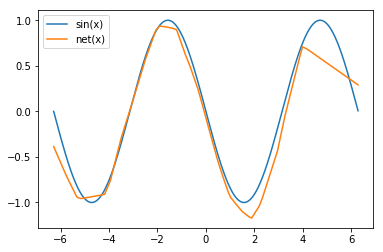

In [9]:
test_x = torch.arange(-2*math.pi, 2*math.pi, step=0.01).unsqueeze(1)
test_y = torch.sin(test_x + t_b)

test_f, _, _ = net(test_x, t_params)

plt.plot(test_x.data.numpy(), test_y.data.numpy(), label='sin(x)')
plt.plot(test_x.data.numpy(), test_f.data.numpy(), label='net(x)')
plt.legend()
plt.savefig('daml-sine.png')